# Noise Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [32]:
import numpy as np
import pandas as pd
from pprint import pprint
from guess_range import *

## Visualize HW Behavior

In [11]:
def compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-6))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [12]:
guess_range=(-3e0, 3e0)
# the number of guess values in the guess range
guess_val_size=4000
# generate the known inputs which is used to test the guess values
known_inputs = np.random.uniform(-1e2, 1e2, 1000)

secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 6.374345698e-2
print('secret_number =', secret_number)

secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = compute_corr(secret_hw, guess_range, known_inputs, guess_val_size)
correlations_1 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size*10))
correlations_2 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size/10))
correlations.sort_values(ascending=False).iloc[:10]

secret_number = 0.06374345698


 0.0630    0.577659
 0.0645    0.555946
-0.0630    0.534999
 0.0615    0.517327
-0.0645    0.508941
 0.0600    0.507869
 0.0660    0.506613
 0.0675    0.483059
-0.0615    0.472375
-0.0660    0.462579
dtype: float64

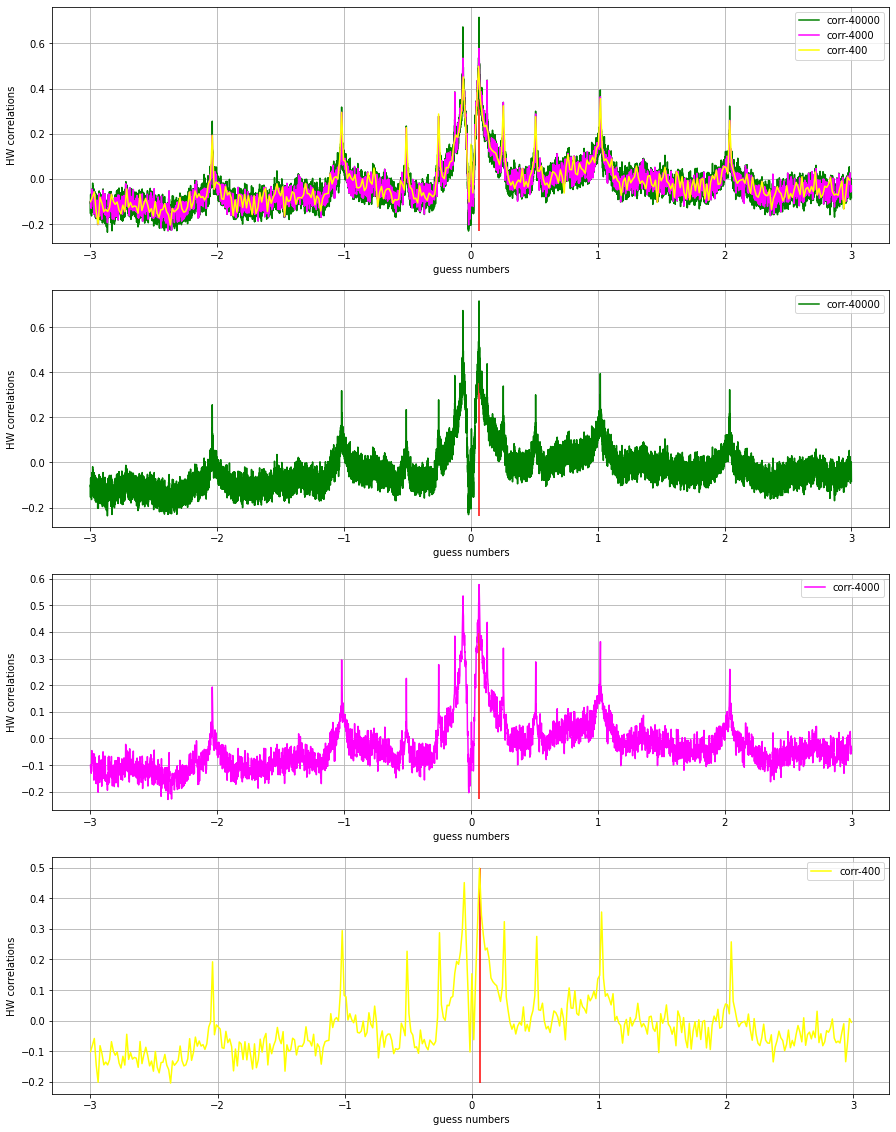

In [13]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
correlations_1.plot(ax=ax[0], label='corr-%s' % correlations_1.shape[0], color='green')
correlations.plot(ax=ax[0], label='corr-%s' % correlations.shape[0], color='magenta')
correlations_2.plot(ax=ax[0], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[0].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_1.plot(ax=ax[1], label='corr-%s' % correlations_1.shape[0], color='green')
ax[1].vlines(secret_number, correlations_1.min(), correlations_1.max(), color='red')

correlations.plot(ax=ax[2], label='corr-%s' % correlations.shape[0], color='magenta')
ax[2].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_2.plot(ax=ax[3], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[3].vlines(secret_number, correlations_2.min(), correlations_2.max(), color='red')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('guess numbers')
    a.set_ylabel('HW correlations')
    
plt.show()

## Analyze with noise - one number

In [17]:
def resize_known_inputs(known_inputs, new_len):
    """
    resize the known input to the new_len
    :param known_inputs: known inputs 
    :param new_len: new size of the know_inputs
    :return: the known
    """
    old_len = len(known_inputs)
    vf = np.vectorize(lambda i: known_inputs[int(i*old_len/new_len)])
    return vf(np.arange(0, new_len))

def add_noise_to_signal(signal, snr):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :return: signal with noise
    """
    
    return (signal + np.random.normal(-0.5, 0.5, len(signal))*(np.max(signal)-np.min(signal))*(1.0-snr))

In [18]:
# the noise frequency is 50 times higher than HW signal frequency. Here we also increase
# the sizes of the computation with 
noise_known_inputs = resize_known_inputs(known_inputs, len(known_inputs) * 50)
no_noise_secret_hw = np.vectorize(hamming_weight)(noise_known_inputs * secret_number)

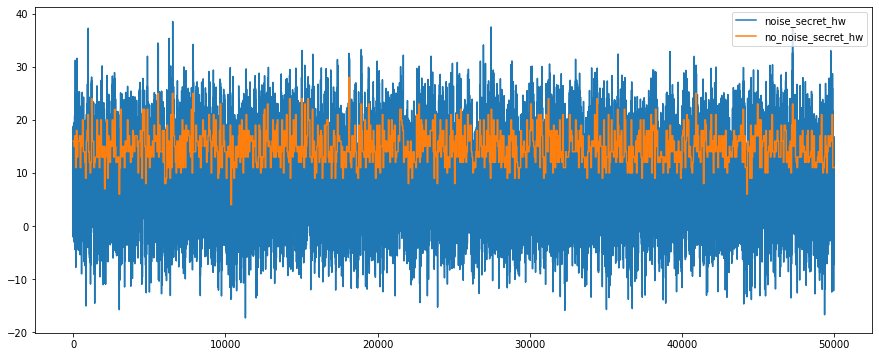

In [19]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_hw = add_noise_to_signal(signal=no_noise_secret_hw, snr=signal_to_noise_ratio)
ax = pd.DataFrame([noise_secret_hw, no_noise_secret_hw], index=['noise_secret_hw', 'no_noise_secret_hw']).T.plot(figsize=(15,6))
ax.legend()

In [8]:
noise_correlations = compute_corr(noise_secret_hw, guess_range, noise_known_inputs, guess_val_size)
print('secret_number =', secret_number)
noise_correlations.sort_values(ascending=False).iloc[:10]

secret_number = 0.06374345698


 0.066    0.301255
-0.066    0.278123
 0.060    0.238903
 0.072    0.234906
-0.060    0.228083
-0.072    0.225437
 0.078    0.213009
 1.020    0.211461
 0.054    0.208832
-0.054    0.199674
dtype: float64

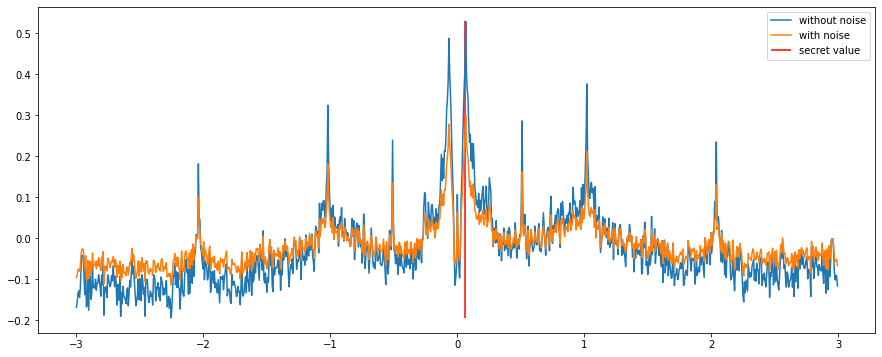

In [9]:
ax = correlations.plot(figsize=(15, 6), label='without noise')
noise_correlations.plot(ax=ax, label='with noise')
ax.vlines(secret_number, 
          min(noise_correlations.min(), correlations.min()),
          max(noise_correlations.max(), correlations.max()), 
          color='red', label='secret value')
ax.legend()

## Analyze with noise - multiple numbers

In [235]:
def add_noise_to_signal(signal, snr, freq):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :param freq: frequency of noise 
    :return: signal with noise
    """
    sig_max = signal.max()
    sig_min = signal.min()
    return signal.apply(lambda x: x +
                        np.average(np.random.normal(-0.5, 0.5, freq)*(sig_max-sig_min)*(1.0-snr)))

In [236]:
guess_range = (0.0, 5.0)
known_input_set = generate_known_inputs(exps=(-2,3), nsize=3000)
precision = 1e-6
n_secret_numbers = 10
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (9,)


In [237]:
secret_numbers_hws = {}
for idx in known_input_set.index:
    secret_numbers_hws[idx] = pd.DataFrame(
        columns=secret_numbers, 
        data=np.vectorize(hamming_weight)(np.asarray(known_input_set.loc[idx]).reshape(-1, 1) * secret_numbers))

In [238]:
secret_numbers_hws[0]

,1.574425,2.209056,0.127109,0.387438,0.316803,3.401172,1.149563,0.394373,4.010487
0,18,22,16,16,17,14,21,18,13
1,20,17,17,17,19,17,22,18,18
2,15,27,17,14,17,21,18,21,15
3,16,21,15,13,13,18,17,15,19
4,20,16,19,20,18,20,17,21,16
...,...,...,...,...,...,...,...,...,...
495,18,18,20,14,22,14,17,19,12
496,18,18,16,17,16,8,15,17,15
497,17,20,14,17,15,11,17,18,7
498,18,17,19,15,17,16,18,19,20


In [283]:
SECRET_VALUE='secret value'
df_index = [INPUT_ID, LOW_VALUE, HIGH_VALUE, CORRELATION, SECRET_VALUE]

In [284]:
%%time
# start guessing... - without noise first
results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        results = pd.concat([results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[1.574425] -2 1.574425 1.574425 1.000000'
'[1.574425] -1 1.574425 1.574425 1.000000'
'[1.574425] 00 1.574425 1.574425 1.000000'
'[1.574425] 01 1.574425 1.574425 1.000000'
'[1.574425] 02 1.574425 1.574425 1.000000'
'[1.574425] 03 1.574425 1.574425 1.000000'
'[2.209056] -2 2.209056 2.209057 0.999403'
'[2.209056] -1 2.209056 2.209057 0.999670'
'[2.209056] 00 2.209056 2.209057 0.999729'
'[2.209056] 01 2.209056 2.209057 0.999867'
'[2.209056] 02 2.209056 2.209057 0.999524'
'[2.209056] 03 2.209056 2.209057 0.999665'
'[0.127109] -2 2.033738 2.033738 0.979496'
'[0.127109] -1 2.033738 2.033738 0.985769'
'[0.127109] 00 2.033738 2.033738 0.969066'
'[0.127109] 01 4.067476 4.067477 0.872568'
'[0.127109] 02 0.127108 0.127109 0.998747'
'[0.127109] 03 2.033738 2.033738 0.968590'
'[0.387438] -2 0.387438 0.387439 0.997486'
'[0.387438] -1 0.387438 0.387439 0.993830'
'[0.387438] 00 0.387438 0.387439 0.997282'
'[0.387438] 01 0.387438 0.387439 0.995150'
'[0.387438] 02 0.387438 0.387439 0.992801'
'[0.387438]

In [291]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.7
noise_secret_numbers_hws = {}
for k in secret_numbers_hws.keys():
    noise_secret_numbers_hws[k] = secret_numbers_hws[k].apply(lambda hw: add_noise_to_signal(signal=hw, snr=signal_to_noise_ratio, freq=50), axis=0)
noise_secret_numbers_hws[0]    

,1.574425,2.209056,0.127109,0.387438,0.316803,3.401172,1.149563,0.394373,4.010487
0,15.772543,19.364614,13.817267,13.525975,14.990781,10.947869,19.493095,15.663380,9.974897
1,18.493386,14.721112,14.279097,14.799689,16.663410,13.478965,19.751045,15.725416,13.966868
2,12.959310,23.970282,14.449450,10.848675,14.721571,17.702802,15.944404,19.116708,12.022227
3,13.615476,18.086538,12.907714,11.146854,10.262173,14.956948,14.708280,13.100039,15.688131
4,18.114967,12.938704,16.244209,17.432914,15.671429,16.542100,14.709499,18.766934,12.950615
...,...,...,...,...,...,...,...,...,...
495,16.252563,15.224376,17.700181,11.506934,19.704263,10.464883,14.964642,17.029948,9.050224
496,15.865015,15.408330,13.735869,14.936651,13.989752,4.846171,12.616125,15.041099,11.989142
497,14.745641,17.165738,11.192981,14.458045,13.017424,7.625083,15.104890,15.703894,4.476253
498,16.320436,14.415950,16.415927,12.556601,14.734975,12.875240,16.338996,17.509132,17.302321


In [ ]:
%%time
# start guessing... - with noise
noise_results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(noise_secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        noise_results = pd.concat([noise_results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[1.574425] -2 1.574425 1.574425 0.993833'
'[1.574425] -1 1.574425 1.574425 0.991518'
'[1.574425] 00 1.574425 1.574425 0.993062'
'[1.574425] 01 1.574425 1.574425 0.991261'
'[1.574425] 02 1.574425 1.574425 0.992848'
'[1.574425] 03 1.574425 1.574425 0.991975'
'[2.209056] -2 2.209056 2.209057 0.990592'
'[2.209056] -1 2.209056 2.209057 0.990442'
'[2.209056] 00 2.209056 2.209057 0.991252'
'[2.209056] 01 2.209056 2.209057 0.991585'
'[2.209056] 02 2.209056 2.209057 0.992619'
'[2.209056] 03 2.209056 2.209057 0.991034'
'[0.127109] -2 2.033738 2.033738 0.973046'
'[0.127109] -1 2.033738 2.033738 0.977766'
'[0.127109] 00 2.033738 2.033738 0.962169'
'[0.127109] 01 4.067476 4.067477 0.863333'
'[0.127109] 02 0.127108 0.127109 0.991354'
'[0.127109] 03 4.067476 4.067477 0.921091'
'[0.387438] -2 0.387438 0.387439 0.990499'
'[0.387438] -1 0.387438 0.387439 0.987406'
'[0.387438] 00 0.387438 0.387439 0.988758'
'[0.387438] 01 0.387438 0.387439 0.986563'
'[0.387438] 02 0.387438 0.387439 0.983768'
'[0.387438]

### Statistics

In [ ]:
GUESSED_VALUE = 'guessed value'
ERROR = 'error'
def statistics(df):
    dft = df.T
    dft[GUESSED_VALUE] = (dft[HIGH_VALUE]+dft[LOW_VALUE])/2.0
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [ ]:
best_corr, best_err = statistics(results)
noise_best_corr, noise_best_err = statistics(noise_results)

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
df = noise_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
ax[2].set_ylabel('Error')
ax[2].set_title('Correlation (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best err,SNR=%0.2f)' % signal_to_noise_ratio)


df = best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
df = noise_best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best err, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
ax[2].set_ylabel('Error')
ax[2].set_title('Correlation (best err, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

In [ ]:
best_err